# <center> Identify Customer Segments - Data Cleansing </center>

## Table of Contents

1. <a href="#Intro">Introduction</a>
2. <a href="#Explo">Explore the data </a>
3. <a href="#Prepr">Pre-processing</a>
    * <a href="#Asses"> 3.1 - Assess Missing Data </a>
        - <a href="#Conve"> 3.1.1 - Convert Missing Value Codes to NaNs </a>
        - <a href="#Missc"> 3.1.2 - Assess Missing Data in Each Column </a>
        - <a href="#Missr"> 3.1.3 - Assess Missing Data in Each Row </a>
    * <a href="#Selec"> 3.2 - Select and Re-Encode Features </a>
        - <a href="#Reenc"> 3.2.1 - Re-Encode Categorical Features </a>
        - <a href="#Engin"> 3.2.2 - Engineer Mixed-Type Features </a> 
        - <a href="#Compl"> 3.2.3 - Complete Feature Selection </a>
    * <a href="#Clean"> 3.3- Create a Cleaning Function </a> 
4. <a href ='#Concl'>Conclusion and next steps </a>

<a id = 'Intro'></a>
## 1. Introduction

Supervised Learning is a main category for machine learning techniques which could be used to find unlabelled patterns in a given dataset. In this project, It is required to identify segments of the population that form the core customer base for a mail-order sales company in `Germany`. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data has been provided by Bertelsmann Arvato Analytics, and represents a real-life data science task.

Generally speaking, applying Machine learning for a specific dataset is a complicated task which requires solid understanding of the data under examination. Furthermore, applying machine learning techniques is usually preceded by a complete data analysis cycle.  

In this project, we have two big different datasets so we divide this project procedure into two separate parts in order to make it more readable, compacatable and easy to follow. 

In this first part, we are going to explore the `General population` dataset in depth and make different cleaning decisions based on some guidelines. We conclude this part with a complete <u>_data cleansing pipeline_ </u> that can be applied for the `Customers` dataset easily. [`Data cleansing`](https://en.wikipedia.org/wiki/Data_cleansing) is the process of detecting and correcting (or removing) corrupt or inaccurate records from a record set, table, or database and refers to identifying incomplete, incorrect, inaccurate or irrelevant parts of the data and then replacing, modifying, or deleting the dirty or coarse data.

Having gained a solid understanding of the data and completed the cleaning procedure then, we are ready for the [Machine Learning part](http://localhost:8888/notebooks/Identify_Customer_Segments.ipynb) which considering applying unsupervised learning pipeline on the cleaned data. 

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from helpers import do_pca, scree_plot, pca_results, map_weights
from sklearn.cluster import KMeans

<a id = 'Explo'></a>
## 2. Explore the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood which can be used to cluster the general population into groups with similar demographic properties. 

_After then_, It is requried to see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are _over-represented_ in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, we load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. 

In [81]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ';')
original_azdias = azdias.copy()
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ';')

In [82]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [83]:
azdias.shape

(891221, 85)

In [84]:
azdias.isna().sum()

AGER_TYP                     0
ALTERSKATEGORIE_GROB         0
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
                         ...  
PLZ8_HHZ                116515
PLZ8_GBZ                116515
ARBEIT                   97216
ORTSGR_KLS9              97216
RELAT_AB                 97216
Length: 85, dtype: int64

In [85]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

In [86]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [87]:
azdias['OST_WEST_KZ']

0         NaN
1           W
2           W
3           W
4           W
         ... 
891216      W
891217      W
891218      W
891219      W
891220      W
Name: OST_WEST_KZ, Length: 891221, dtype: object

In [88]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [89]:
feat_info.index = feat_info.attribute
feat_info.drop('attribute', axis = 1, inplace = True)
original_feat_info = feat_info.copy()
feat_info

,information_level,type,missing_or_unknown
attribute,,,
AGER_TYP,person,categorical,"[-1,0]"
ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
ANREDE_KZ,person,categorical,"[-1,0]"
CJT_GESAMTTYP,person,categorical,[0]
FINANZ_MINIMALIST,person,ordinal,[-1]
...,...,...,...
PLZ8_HHZ,macrocell_plz8,ordinal,[-1]
PLZ8_GBZ,macrocell_plz8,ordinal,[-1]
ARBEIT,community,ordinal,"[-1,9]"


In [90]:
feat_info.describe()

,information_level,type,missing_or_unknown
count,85,85,85
unique,9,5,9
top,person,ordinal,[-1]
freq,43,49,26


In [91]:
feat_info.type.unique()

array(['categorical', 'ordinal', 'numeric', 'mixed', 'interval'],
      dtype=object)

In [92]:
feat_info.missing_or_unknown.unique()

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

In [93]:
feat_info.query('missing_or_unknown == "[XX]"')

,information_level,type,missing_or_unknown
attribute,,,
CAMEO_DEU_2015,microcell_rr4,categorical,[XX]


In [94]:
azdias.query('CAMEO_DEU_2015 == "XX"')

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
2511,-1,2,2,6.0,4,2,4,3,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,6.0,5.0
4569,-1,3,2,2.0,4,2,3,4,1,1,...,1.0,3.0,3.0,2.0,4.0,5.0,3.0,5.0,5.0,4.0
9803,2,4,2,2.0,5,1,5,1,1,3,...,2.0,3.0,3.0,0.0,3.0,3.0,3.0,4.0,8.0,3.0
16700,3,3,2,1.0,5,1,5,1,3,3,...,3.0,2.0,2.0,1.0,1.0,5.0,5.0,3.0,5.0,2.0
16883,2,4,2,2.0,5,1,5,1,2,3,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,3.0,5.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
868148,-1,1,2,3.0,1,5,3,5,5,5,...,2.0,3.0,2.0,1.0,1.0,4.0,3.0,2.0,6.0,3.0
874917,-1,1,2,4.0,1,4,3,5,5,4,...,2.0,3.0,2.0,1.0,1.0,4.0,3.0,1.0,4.0,1.0
882189,-1,3,2,3.0,5,2,4,3,2,2,...,4.0,2.0,1.0,0.0,1.0,5.0,5.0,3.0,6.0,2.0
882231,-1,4,1,1.0,5,2,4,2,3,1,...,2.0,3.0,2.0,1.0,1.0,4.0,4.0,2.0,2.0,2.0


In [95]:
feat_info.value_counts('type')

type
ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
dtype: int64

In [96]:
featurestypes = list(feat_info.type)

<a id = 'Prepr'></a>
## 3. Preprocessing

The feature summary file contains a summary of properties for each demographics data column which can be used to make better cleaning decisions.

<a id = 'Asses'></a>
### 3.1 - Assess Missing Data

First of all, we should assess the demographics data in terms of missing data.

<a id = 'Conve'></a>
#### 3.1.1 -  Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. With the aid of a little parsing, it can be used to further clean the data.

To accomplish this step we convert the data that matches a `missing` or `unknown` value code into a `numpy NaN` value in order to see how much data takes on a `missing` or `unknown` code, and how much data is naturally missing, as a point of interest.

In [97]:
# Identify missing or unknown data values and convert them to NaNs.
a = list(feat_info['missing_or_unknown'])
ToNan = [i.strip('][,').split(',') for i in a]

In [98]:
azdias.isna().sum()

AGER_TYP                     0
ALTERSKATEGORIE_GROB         0
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
                         ...  
PLZ8_HHZ                116515
PLZ8_GBZ                116515
ARBEIT                   97216
ORTSGR_KLS9              97216
RELAT_AB                 97216
Length: 85, dtype: int64

In [99]:
print('Replacing missing values per column with Nan...')
for i,j in zip(azdias.columns, ToNan):
    NanIndices = azdias.query('{} == {}'.format(i, j)).index
    azdias.at[NanIndices,i] = np.NaN
print('Replacing done')

Replacing missing values per column with Nan...
Replacing done


In [100]:
azdias.isna().sum()

AGER_TYP                685843
ALTERSKATEGORIE_GROB      2881
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
                         ...  
PLZ8_HHZ                116515
PLZ8_GBZ                116515
ARBEIT                   97375
ORTSGR_KLS9              97274
RELAT_AB                 97375
Length: 85, dtype: int64

<a id = 'Missc'></a>
#### 3.1.2 -  Assess Missing Data in Each Column

A common problem occurs in real-world datasets when a few columns that are outliers in terms of the proportion of values that are missing. Thus, It is interesting to visualize the distribution of the missing values to find these columns. 

While some of these columns might have justifications for keeping or re-encoding the data, for this project we just remove them from the dataframe. 

In [102]:
# Perform an assessment of how much missing data there is in each column of the dataset.
MissingValues = pd.DataFrame([azdias.isna().sum(),(azdias.isna().sum() / azdias.shape[0]) * 100], 
                                index = ['Values','Per'], columns = azdias.columns).T
MissingValues['Information_level'] = feat_info.loc[MissingValues.index,:].information_level

In [103]:
MissingValues.head()

,Values,Per,Information_level
AGER_TYP,685843.0,76.955435,person
ALTERSKATEGORIE_GROB,2881.0,0.323264,person
ANREDE_KZ,0.0,0.000000,person
CJT_GESAMTTYP,4854.0,0.544646,person
FINANZ_MINIMALIST,0.0,0.000000,person


In [137]:
MissingValues.groupby('Information_level').describe()

Values                                                    \
                   count           mean            std       min       25%   
Information_level                                                            
building             7.0   91882.857143    8299.597429   73969.0   93148.0   
community            3.0   97341.333333      58.312377   97274.0   97324.5   
household            7.0  183101.714286  200747.164224   18348.0   73499.0   
macrocell_plz8       8.0  115175.625000    3788.324580  105800.0  116515.0   
microcell_rr3        6.0  190524.000000  140110.813287  133324.0  133324.0   
microcell_rr4        3.0   99352.000000       0.000000   99352.0   99352.0   
person              43.0   68970.395349  176393.003050       0.0       0.0   
postcode             3.0   93740.000000       0.000000   93740.0   93740.0   
region_rr1           5.0  109492.200000   64230.933367    4854.0   93155.0   

                                                  Per                        \
                        50%       75%       max count       mean        std   
Information_level                                                             
building            93148.0   95078.0   99611.0   7.0  10.309772   0.931261   
community           97375.0   97375.0   97375.0   3.0  10.922244   0.006543   
household           73499.0  229127.5  584612.0   7.0  20.545040  22.524959   
macrocell_plz8     116515.0  116515.0  116515.0   8.0  12.923352   0.425071   
microcell_rr3      133324.0  133324.0  476524.0   6.0  21.377863  15.721220   
microcell_rr4       99352.0   99352.0   99352.0   3.0  11.147852   0.000000   
person                  0.0   77792.0  889061.0  43.0   7.738866  19.792285   
postcode            93740.0   93740.0   93740.0   3.0  10.518154   0.000000   
region_rr1         133324.0  158064.0  158064.0   5.0  12.285640   7.207071   

                                                                          
                         min        25%        50%        75%        max  
Information_level                                                         
building            8.299737  10.451729  10.451729  10.668285  11.176913  
community          10.914689  10.920355  10.926022  10.926022  10.926022  
household           2.058749   8.247000   8.247000  25.709392  65.596749  
macrocell_plz8     11.871354  13.073637  13.073637  13.073637  13.073637  
microcell_rr3      14.959701  14.959701  14.959701  14.959701  53.468668  
microcell_rr4      11.147852  11.147852  11.147852  11.147852  11.147852  
person              0.000000   0.000000   0.000000   8.728699  99.757636  
postcode           10.518154  10.518154  10.518154  10.518154  10.518154  
region_rr1          0.544646  10.452514  14.959701  17.735668  17.735668

In [110]:
MissingValues.describe()

,Values,Per
count,85.000000,85.000000
mean,98516.811765,11.054139
std,146604.203317,16.449815
min,0.000000,0.000000
25%,0.000000,0.000000
50%,93148.000000,10.451729
75%,116515.000000,13.073637
max,889061.000000,99.757636


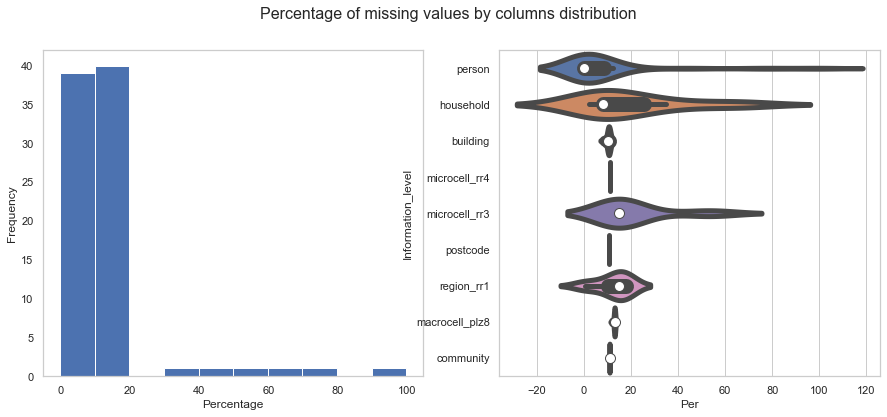

In [143]:
fig, ax = plt.subplots(1,2, figsize = (15,6))
fig.suptitle('Percentage of missing values by columns distribution', size = 16);
ax[0].grid();
ax[0].set_xlabel('Percentage');
ax[0].set_ylabel('Frequency');
ax[0].hist(MissingValues.Per);
sns.set_theme(style="whitegrid");
sns.violinplot(ax = ax[1], data = MissingValues, y = 'Information_level', x = 'Per', linewidth = 5, scale = 'width');

It is clear that most columns suffer from less than 20% of missing data. However, some irregular columns exhibits up to 99.75% missing entries. 

In [ ]:
Threshold = 20
Todelete = MissingValues.query('Per > {}'.format(Threshold))
DeletedColumns = azdias.loc[:,Todelete.index]

In [ ]:
DeletedColumns

In [ ]:
# Investigate patterns in the amount of missing data in each column.
feat_info.loc[DeletedColumns.columns,:]

In [ ]:
# Remove the outlier columns from the dataset.
azdias.drop(Todelete.index, axis = 1 , inplace = True)
azdias.shape[1]

In [ ]:
feat_info.shape

In [ ]:
feat_info.drop(Todelete.index, axis = 0 , inplace = True)

In [ ]:
azdias.head()

#### Discussion 1.1.2: Assess Missing Data in Each Column

A good measure to select the deleted columns based on the amount of missing data is the **percentage of missing value by columns**. Basically, it is justified to parametrize each decision so that we can change it later easily if it leads to poor results at the end of the day. An initial estimate is stored in `Threshold` which leads to removal of the data stored in `Todelete` data frame. 

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

<a id = 'Missr' ></a>
#### 3.1.3 -  Assess Missing Data in Each Row

As with the columns, we divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Selecting five columns and compare the distribution of values can serve for this task. 

In [ ]:
# How much data is missing in each row of the dataset?

MissingValuesRows = pd.DataFrame([azdias.isna().sum(axis = 1),(azdias.isna().sum(axis = 1) / azdias.shape[1]) * 100],
                                 columns = azdias.index, index = ['Value','Per']).T

In [ ]:
MissingValuesRows.describe()

In [ ]:
azdias.shape[0]

In [ ]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
Threshold = 3.79
TodeleteRows = MissingValuesRows.query('Per > {}'.format(Threshold))
DeletedRows = azdias.loc[TodeleteRows.index,:]
azdias.drop(TodeleteRows.index, axis = 0 , inplace = True)
azdias.shape[0]

In [ ]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def compare_dist(col,data1,data2):
    fig, axs = plt.subplots(1,2, figsize = (15,5))
    sns.countplot(ax = axs[0], data = data1, x = col )
    sns.countplot(ax = axs[1], data = data2, x = col )


In [ ]:
plotcol = ['ALTERSKATEGORIE_GROB', 'ANREDE_KZ','CJT_GESAMTTYP','FINANZ_MINIMALIST']
for c in plotcol:
    compare_dist(c,DeletedRows,azdias)

In [ ]:
azdias.isna().sum()

#### Discussion 1.1.3: Assess Missing Data in Each Row

For the selected test columns, it is clear that rows with multiple missing values affect the distribution of the data significantly. Hence, It should be noted that dropping this data change the data to some extent.  

<a id = 'Selec'></a>
### 3.2 -  Select and Re-Encode Features

Checking for missing data isn't the only way to prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, It is necessary to make a few encoding changes or additional assumptions to be able to make progress. 

In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. After checking the third column of the feature summary (`feat_info`) for a summary of types of measurement, we do the following: 

- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, It is assumed that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, we will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether to keep, drop, or re-encode each. Then, in the last part, we will create a new data frame with only the selected and engineered columns.

In [ ]:
# How many features are there of each data type?
feat_info.value_counts('type')

<a id = 'Reenc'></a>
#### 3.2.1 - Re-Encode Categorical Features

For categorical data, we would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, we perform one of the following:
- For binary (two-level) categoricals that take numeric values, we can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, we need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), we can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. 

In [ ]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

cat_var = azdias.loc[:,list(feat_info.query('type =="categorical"').index)]
unique_per_cat = [(i,cat_var[i].nunique()) for i in cat_var.columns]
bin_cat = [i for i in cat_var.columns if cat_var[i].nunique() == 2]
Multi_cat = [i for i in cat_var.columns if cat_var[i].nunique() > 2]
To_OH = pd.concat([azdias.loc[:, Multi_cat], azdias.loc[:, bin_cat].OST_WEST_KZ], axis = 1)
To_OH

In [ ]:
# Re-encode categorical variable(s) to be kept in the analysis.
OH_bin_obj = preprocessing.OneHotEncoder().fit(To_OH)
OH_cat = OH_bin_obj.transform(To_OH)

In [ ]:
OH_cat = pd.DataFrame(OH_cat.toarray(), columns = OH_bin_obj.get_feature_names())

In [ ]:
OH_cat

In [ ]:
# drop categorical features
azdias.drop(cat_var , axis = 1 , inplace = True)
feat_info.drop(cat_var, axis = 0, inplace = True)
# Append one hot encoded data 
azdias = pd.concat([azdias, OH_cat], axis = 1)

In [ ]:
feat_info

#### Discussion 1.2.1: Re-Encode Categorical Features

- One hot encoding for binary non numeric feature
- One hot encoding for Multi_cat

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

<a id = 'Engin'></a>
#### 3.2.2 -  Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [ ]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
#azdias.PRAEGENDE_JUGENDJAHRE

In [ ]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
Wealth = [int(i[0]) if type(i) == str else i for i in azdias.CAMEO_INTL_2015]
LifeStage = [int(i[1])  if type(i) == str else i for i in azdias.CAMEO_INTL_2015]
CAMEO_INTL_2015 = pd.DataFrame(list(zip(Wealth, LifeStage)), columns = ['Waelth', 'LifeStage'])
CAMEO_INTL_2015

In [ ]:
# drop original feature
azdias.drop('CAMEO_INTL_2015' , axis = 1 , inplace = True)
feat_info.drop('CAMEO_INTL_2015', axis = 0 , inplace = True)
# append new features
azdias = pd.concat([azdias,CAMEO_INTL_2015] , axis = 1)

In [ ]:
#mixed_var = azdias.loc[:,list(feat_info.query('type =="mixed"').index)]
azdias.drop(feat_info.query('type =="mixed"').index, axis = 1, inplace = True)

In [ ]:
azdias

#### Discussion 1.2.2: Engineer Mixed-Type Features
- Drop other mixed variables

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

<a id = 'Compl'></a>
#### 3.2.3 -  Complete Feature Selection

In order to finish this step up, we need to make sure that the data frame now only has the columns that we want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

In [ ]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [ ]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



<a id = 'Clean'></a>
### 3.3 -  Create a Cleaning Function

Even though we've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that we'll need to perform the same cleaning steps on the customer demographics data. In this substep, we define the data cleansing pipeline including selection, encoding, and re-engineering steps performed above.

In [ ]:
def clean_data(df, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics data
    
    INPUT: 
        - df: Demographics DataFrame
        - feat_info: Information about df columns
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """

    print('Data cleansing pipeline...')
    ### Main cleaning steps:    
    ## 1- convert missing value codes into NaNs, ...
    print('\t1-Replacing missing values per column with Nan...')
    a = list(feat_info['missing_or_unknown'])
    ToNan = [i.strip('][,').split(',') for i in a]
    for i,j in zip(df.columns, ToNan):
        NanIndices = df.query('{} == {}'.format(i, j)).index
        df.at[NanIndices,i] = np.NaN

    print('\t\tReplacing done')
    # ------------------------------------------------------------------------------------------------ 
    ## 2- Remove selected columns and rows 
    print('\t2-Removing the outliars columns and rows...')
    # 2.1- Perform an assessment of how much missing data there is in each column of the dataset.
    
    MissingValues = pd.DataFrame([df.isna().sum(),(df.isna().sum() / df.shape[0]) * 100], 
                                    index = ['Values','Per'], 
                                 columns = df.columns).T
    Threshold = 20
    Todelete = MissingValues.query('Per > {}'.format(Threshold))
    DeletedColumns = df.loc[:,Todelete.index]
    
    # 2.2- Remove the outlier columns from the dataset
    
    df.drop(Todelete.index, axis = 1 , inplace = True)
    feat_info.drop(Todelete.index, axis = 0 , inplace = True)
    
    # 2.3- Perform an assessment of how much missing data there is in each row of the dataset

    MissingValuesRows = pd.DataFrame([df.isna().sum(axis = 1),(df.isna().sum(axis = 1) / df.shape[1]) * 100],
                                     columns = df.index, index = ['Value','Per']).T
    
    # 2.4- Divide the data into two subsets based on the number of missing values in each row.
    Threshold = 3.79
    TodeleteRows = MissingValuesRows.query('Per > {}'.format(Threshold))
    DeletedRows = df.loc[TodeleteRows.index,:]
    df.drop(TodeleteRows.index, axis = 0 , inplace = True)
    print('\t\tRemoving the outliars columns and rows done')
    # ------------------------------------------------------------------------------------------------
    
    ## 3- Select, Re-encode, and Engineer column values.
    print('\t3-Feature Engineering...')
    # 3.1- Assess categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?

    cat_var = df.loc[:,list(feat_info.query('type =="categorical"').index)]
    unique_per_cat = [(i,cat_var[i].nunique()) for i in cat_var.columns]
    bin_cat = [i for i in cat_var.columns if cat_var[i].nunique() == 2]
    Multi_cat = [i for i in cat_var.columns if cat_var[i].nunique() > 2]
    To_OH = pd.concat([df.loc[:, Multi_cat], df.loc[:, bin_cat].OST_WEST_KZ], axis = 1)
    
    # 3.2- Re-encode categorical variable(s) to be kept in the analysis.
    OH_bin_obj = preprocessing.OneHotEncoder().fit(To_OH)
    OH_cat = OH_bin_obj.transform(To_OH)
    OH_cat = pd.DataFrame(OH_cat.toarray(), columns = OH_bin_obj.get_feature_names())
    
    # 3.3- Drop categorical features
    df.drop(cat_var , axis = 1 , inplace = True)
    feat_info.drop(cat_var, axis = 0, inplace = True)
    
    # 3.4- Append one hot encoded data 
    df = pd.concat([df, OH_cat], axis = 1)
    
    # 3.5- Return the cleaned dataframe.
    Wealth = [int(i[0]) if type(i) == str else i for i in df.CAMEO_INTL_2015]
    LifeStage = [int(i[1])  if type(i) == str else i for i in df.CAMEO_INTL_2015]
    CAMEO_INTL_2015 = pd.DataFrame(list(zip(Wealth, LifeStage)), columns = ['Waelth', 'LifeStage'])
    
    # 3.6- Drop original feature
    df.drop('CAMEO_INTL_2015' , axis = 1 , inplace = True)
    feat_info.drop('CAMEO_INTL_2015', axis = 0 , inplace = True)
    
    # 3.7- Append new features
    df = pd.concat([df,CAMEO_INTL_2015] , axis = 1)
    df.drop(feat_info.query('type =="mixed"').index, axis = 1, inplace = True)
    print('\t\tFeature Engineering done')
    # ------------------------------------------------------------------------------------------------
    ## 4- Remove all the missing values
    print('\t4-Removing missing values...')
    df.dropna(inplace = True)
    print('\t\t-Removing missing values done.')
    # ------------------------------------------------------------------------------------------------
    print('Cleaning pipeline done')
    return df

In [ ]:
original_azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ';')

# Load in the feature summary file.
original_feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ';')
original_feat_info.index = original_feat_info.attribute
original_feat_info.drop('attribute', axis = 1, inplace = True)
df = clean_data(original_azdias, original_feat_info)
df

In [ ]:
# save the cleaned data for later use
df.to_csv('Udacity_AZDIAS_Subset_Cleaned.csv')

<a id = 'Concl'></a>
## 4. Conclusion and next steps

In this notebook, we performed a complete pipeline for data cleansing in order to prepare for applying unsupervised learning techniques as well as extracting insights that could be applied for customer dataset in [Machine Learning Notebook](http://localhost:8888/notebooks/Identify_Customer_Segments.ipynb)